This assignment challenges you to explore the power of Boosting
methods. You will move beyond a single model and investigate how Boosting approaches improve generalization by correcting residual errors in sequential learners.
By the end of this assignment, you should be able to:

*   Train and tune tree-based and boosting models.
*   Analyze the bias-variance trade-off through validation results and boosting dynamics.
*   Visualize feature importance and interpret how boosting models evolve during training.

I used Kaggle's Home Credit Default Risk Dataset to predict whether an applicant will repay a loan, using a wide range of application, credit,
and behavioral data.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score, precision_recall_curve, mean_squared_error, f1_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     learning_curve, validation_curve)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.callback import EarlyStopping

pd.set_option("display.max_colwidth", 120)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AML/HW2/application_train.csv')

# Data Preparation

In [ ]:
# Number of each type of column
df.dtypes.value_counts()

,count
float64,65
int64,41
object,16


In [ ]:
print(f"Total number of applications in the dataset: {len(df)}")

Total number of applications in the dataset: 307511


In [ ]:
df.head().T # Transposed for readability

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


There are columns that are highly correlated with each other (_AVG suffix, _MODE suffix, _MEDI suffix). I should probably pick one of these for each feature.

In [ ]:
df_processed = df.copy()
le = LabelEncoder()

categorical_cols = df.select_dtypes('object').columns.tolist()
for col in categorical_cols:
    print(col)
    df_processed[col] = df_processed[col].fillna('Missing') #Adding 'Missing' to any NaN data
    df_processed[col] = le.fit_transform(df_processed[col])

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


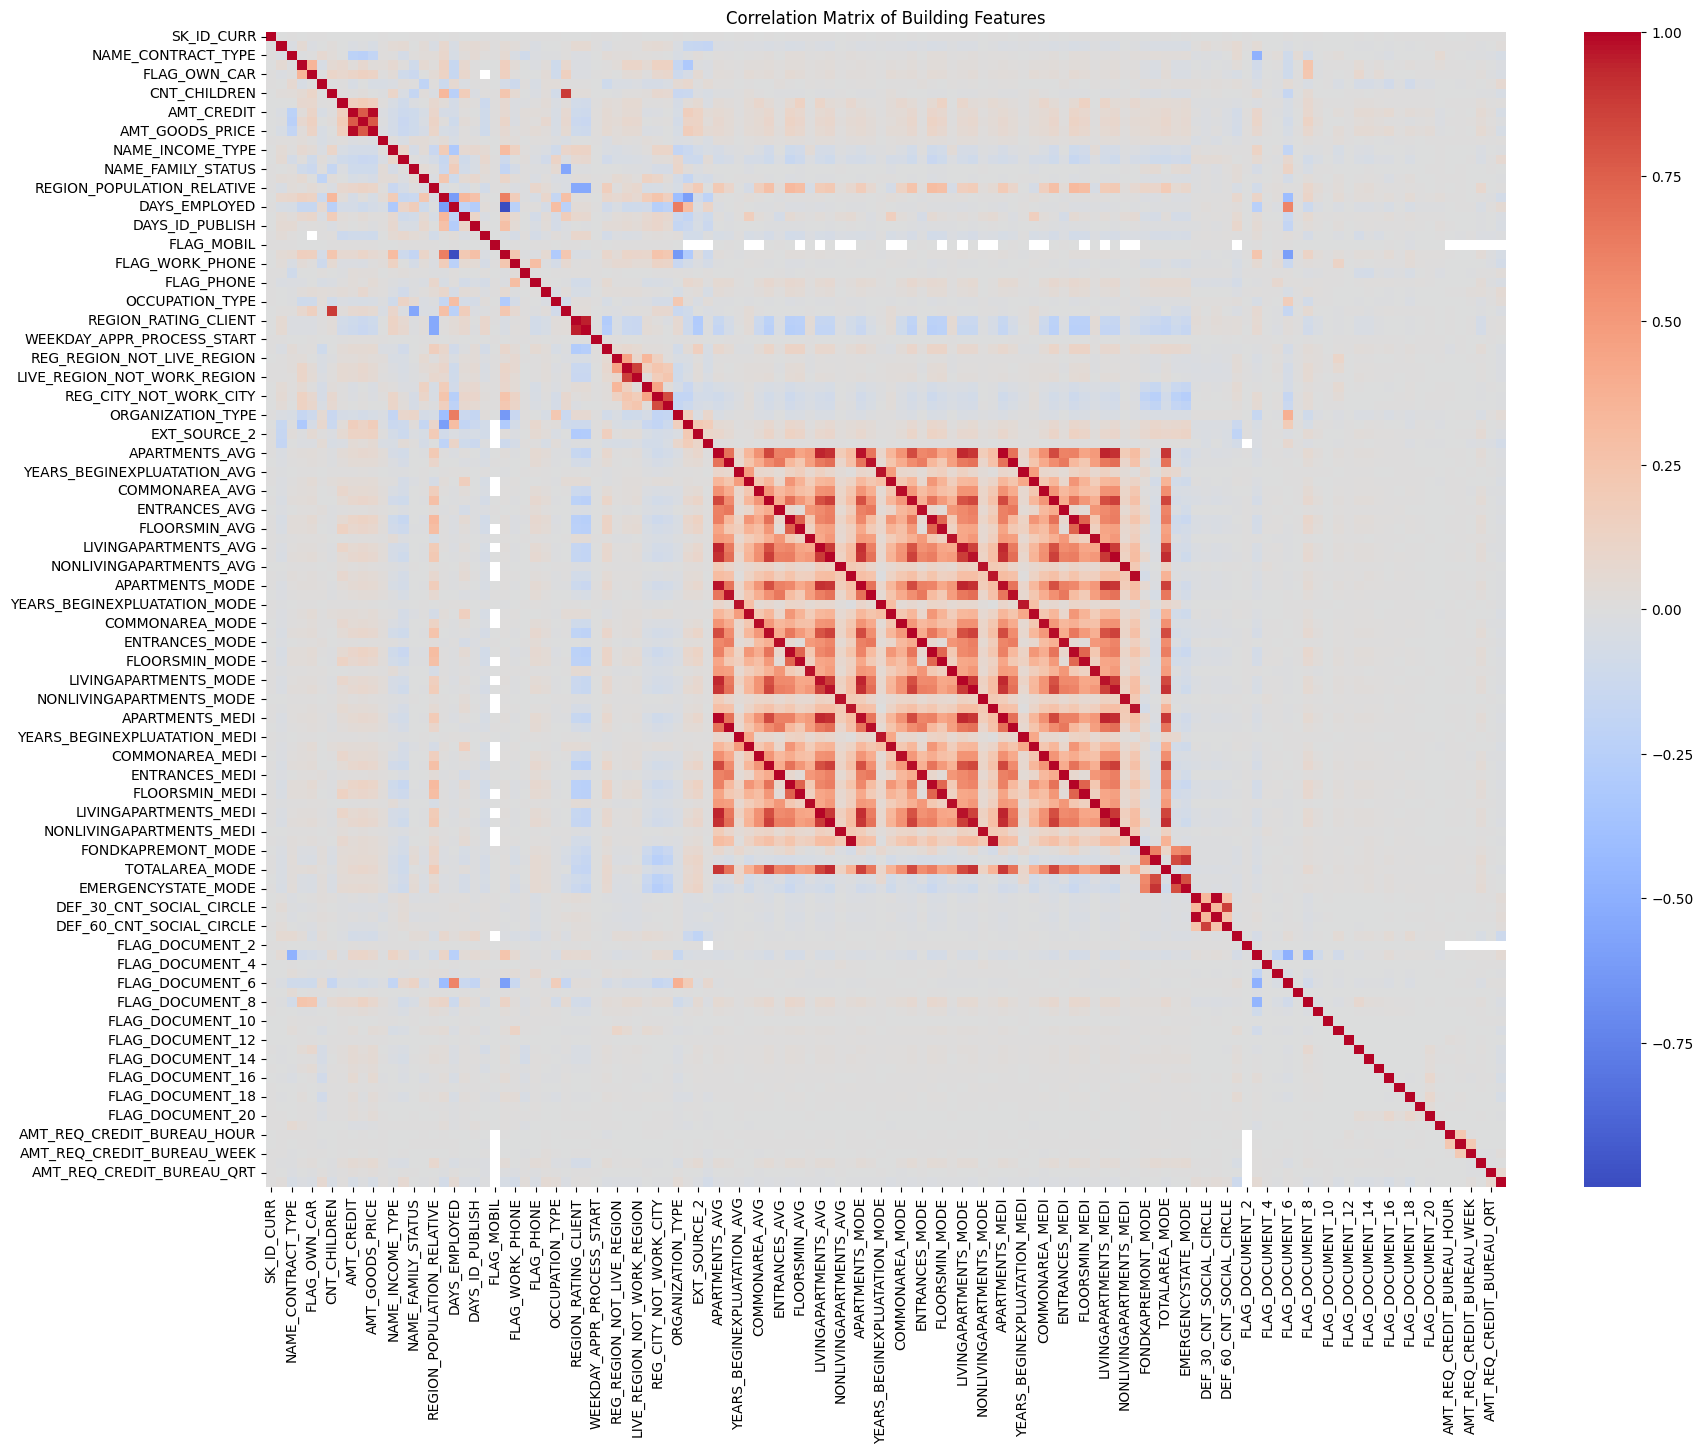

In [ ]:
# Compute the correlation matrix
correlation_matrix = df_processed.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix of Building Features')
plt.show()

Clearly there are highly correlated features, which makes sense. I should just pick a set. Will choose median as that is less sensitive to outliers.

A dataset with many uncorrelated features is ideal. It means each feature provides potentially unique and independent information for the model to use. If all features were highly correlated, they would be redundant, and the model would have less unique information to learn from.

In [ ]:
cols_to_drop = []
all_cols_set = set(df.columns)

for col_name in df.columns:
    if col_name.endswith('_AVG'):
        # Get the base feature name (e.g., 'APARTMENTS' from 'APARTMENTS_AVG')
        base_name = col_name.replace('_AVG', '')

        # Check if a corresponding '_MEDI' column exists
        if f"{base_name}_MEDI" in all_cols_set:
            cols_to_drop.append(col_name)

    elif col_name.endswith('_MODE'):
        # Get the base feature name (e.g., 'APARTMENTS' from 'APARTMENTS_MODE')
        base_name = col_name.replace('_MODE', '')

        # Check if a corresponding '_MEDI' column exists
        if f"{base_name}_MEDI" in all_cols_set:
            cols_to_drop.append(col_name)

# Now, drop the identified redundant columns
print(f"Dropping {len(cols_to_drop)} redundant columns...")
df_cleaned = df.drop(columns=cols_to_drop)

print("Columns dropped:", cols_to_drop)
print(f"Remaining columns: {len(df_cleaned.columns)}")

Dropping 28 redundant columns...
Columns dropped: ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE']
Remaining columns: 94


In [ ]:
# Data Validation Step for Numerical Columns
print("--- Checking Min/Max values of numerical columns before imputation ---")
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}') # Format for readability

print(df_cleaned[numerical_cols].describe().T[['min', 'max']]) # Transpose for readability

pd.reset_option('display.max_rows')
pd.reset_option('display.float_format')

--- Checking Min/Max values of numerical columns before imputation ---
                                    min            max
SK_ID_CURR                   100,002.00     456,255.00
TARGET                             0.00           1.00
CNT_CHILDREN                       0.00          19.00
AMT_INCOME_TOTAL              25,650.00 117,000,000.00
AMT_CREDIT                    45,000.00   4,050,000.00
AMT_ANNUITY                    1,615.50     258,025.50
AMT_GOODS_PRICE               40,500.00   4,050,000.00
REGION_POPULATION_RELATIVE         0.00           0.07
DAYS_BIRTH                   -25,229.00      -7,489.00
DAYS_EMPLOYED                -17,912.00     365,243.00
DAYS_REGISTRATION            -24,672.00           0.00
DAYS_ID_PUBLISH               -7,197.00           0.00
OWN_CAR_AGE                        0.00          91.00
FLAG_MOBIL                         0.00           1.00
FLAG_EMP_PHONE                     0.00           1.00
FLAG_WORK_PHONE                    0.00          

Negative values in DAYS_ columns is ok, because the days are measured relative to the date of the application.

In [ ]:
# checking missing data
total = df_cleaned.isnull().sum().sort_values(ascending = False)
percent = (df_cleaned.isnull().sum()/df_cleaned.isnull().count()*100).sort_values(ascending = False)
missing_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630
YEARS_BUILD_MEDI,204488,66.497784
OWN_CAR_AGE,202929,65.990810
LANDAREA_MEDI,182590,59.376738
BASEMENTAREA_MEDI,179943,58.515956
EXT_SOURCE_1,173378,56.381073


There are a lot of null values in some columns. Either I exclude those columns or I exclude the data.  

Are there any null values that are supposed to be 0 though?

It is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

In [ ]:
# Separate features / target
X = df_cleaned.drop(columns=["TARGET"])
y = df_cleaned["TARGET"]

# Train / Test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [ ]:
# Imputation with 0
# These columns represent physical attributes of a building. It is reasonable to assume
# that a missing value (NaN) indicates the absence of that feature (e.g., no common area,
# no basement), so we fill with 0.

cols_to_fill_zero = [
    'COMMONAREA_MEDI', #size of common area could be 0 (studio)
    'NONLIVINGAPARTMENTS_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'BASEMENTAREA_MEDI', #area of basement could be 0
    'ELEVATORS_MEDI', #number of elevators could be 0
    'APARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE'
]

existing_zero_cols = [col for col in cols_to_fill_zero if col in X_train.columns and X_train[col].isnull().any()]
if existing_zero_cols:
    print(f"\n Filling the following columns with 0:")
    print(existing_zero_cols)
    X_train[existing_zero_cols] = X_train[existing_zero_cols].fillna(0)
    X_test[existing_zero_cols] = X_test[existing_zero_cols].fillna(0)
print("-" * 30 + "\n")


# Imputation with Median
# For these numerical columns, a missing value means the data is unknown, not zero.
# For example, a building must have entrances, and an applicant has an external score source,
# so a value of 0 would be incorrect. We use the median because it is robust to outliers.

numerical_cols_with_nan = X_train.select_dtypes(include=np.number).columns[X_train.select_dtypes(include=np.number).isnull().any()].tolist()
if numerical_cols_with_nan:
    print(f"\n[Strategy 2] Imputing the following numerical columns with their median:")
    print(numerical_cols_with_nan)
    medians = X_train[numerical_cols_with_nan].median()
    X_train[numerical_cols_with_nan] = X_train[numerical_cols_with_nan].fillna(medians)
    X_test[numerical_cols_with_nan] = X_test[numerical_cols_with_nan].fillna(medians)

# Fill categorical NaNs with a placeholder string 'Missing'
categorical_cols_with_nan = X_train.select_dtypes(include='object').columns[X_train.select_dtypes(include='object').isnull().any()].tolist()
if categorical_cols_with_nan:
    print(f"\n[Strategy 3] Imputing the following categorical columns with the placeholder 'Missing':")
    print(categorical_cols_with_nan)
    X_train[categorical_cols_with_nan] = X_train[categorical_cols_with_nan].fillna('Missing')
    X_test[categorical_cols_with_nan] = X_test[categorical_cols_with_nan].fillna('Missing')

# Final Verification
# Check if there are any remaining null values
total = X_train.isnull().sum().sort_values(ascending = False)
percent = (X_train.isnull().sum()/X_train.isnull().count()*100).sort_values(ascending = False)
missing_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_data.head(10)


 Filling the following columns with 0:
['COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'ELEVATORS_MEDI', 'APARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']
------------------------------


[Strategy 2] Imputing the following numerical columns with their median:
['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

[Strategy 3] Imputing the following categorical columns with the placeholder 'Missing':
['NAME_TYPE_SUITE', 

,Total,Percent
SK_ID_CURR,0,0.0
NAME_CONTRACT_TYPE,0,0.0
CODE_GENDER,0,0.0
FLAG_OWN_CAR,0,0.0
FLAG_OWN_REALTY,0,0.0
CNT_CHILDREN,0,0.0
AMT_INCOME_TOTAL,0,0.0
AMT_CREDIT,0,0.0
AMT_ANNUITY,0,0.0
AMT_GOODS_PRICE,0,0.0


In [ ]:
# Number of unique classes in each object column
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


I have to apply label encoding or one-hot encoding to categorical variables. Will use label encoding to limit the number of columns generated.

In [ ]:
# Categorical Encoding Step
print("\n--- Encoding categorical features ---")
le = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

if categorical_cols:
    print(f"Applying LabelEncoder to the following columns:")
    print(categorical_cols)
    for col in categorical_cols:
        # Combine all possible categories from train and test sets
        all_categories = pd.concat([X_train[col], X_test[col]]).astype(str).unique()
        le.fit(all_categories)
        # Transform train and test sets
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
else:
    print("No categorical features to encode.")


--- Encoding categorical features ---
Applying LabelEncoder to the following columns:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


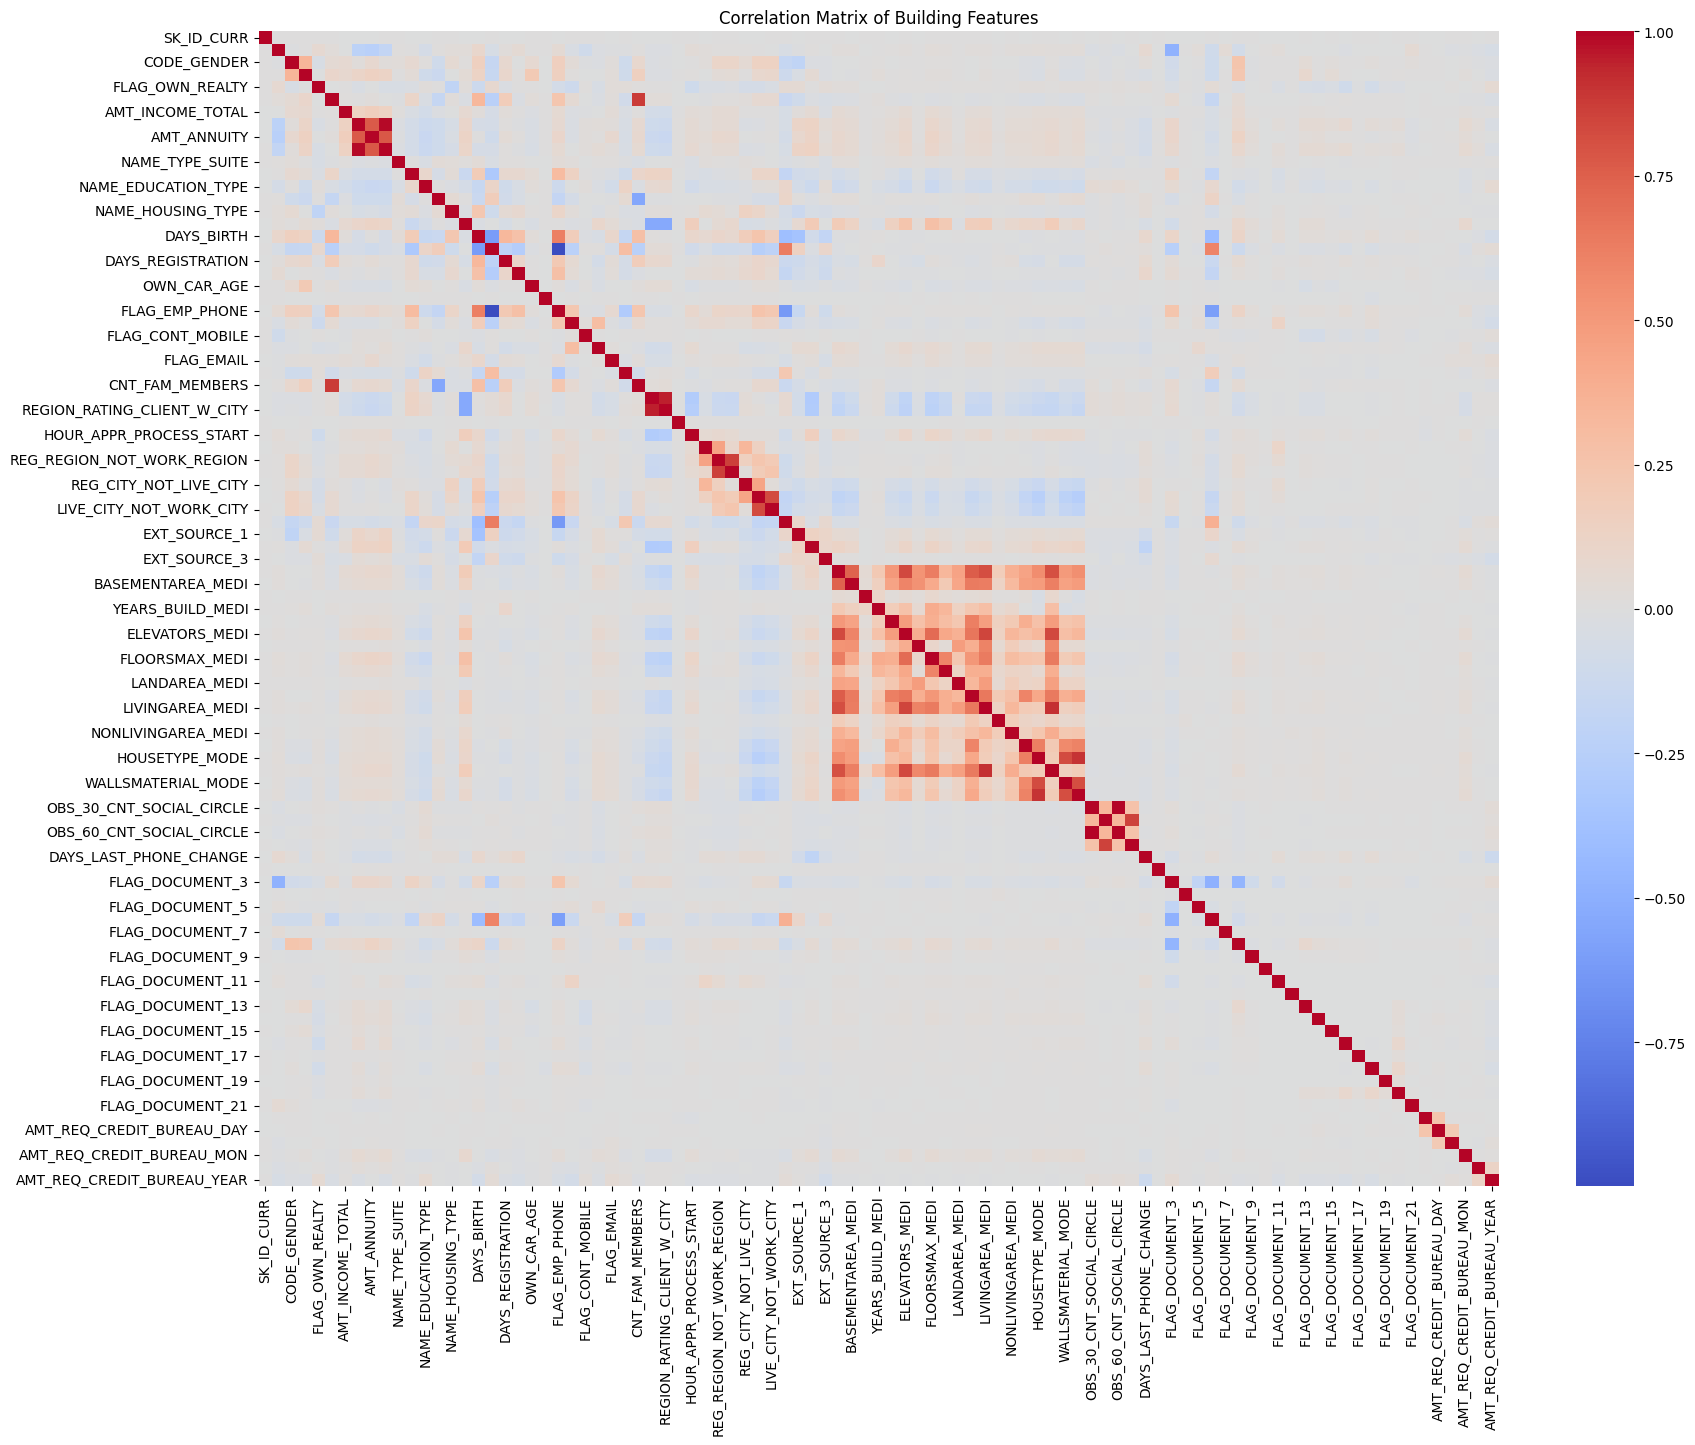

In [ ]:
# Compute the correlation matrix for the whole dataset to confirm correlation was reduced
correlation_matrix = X_train.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix of Building Features')
plt.show()

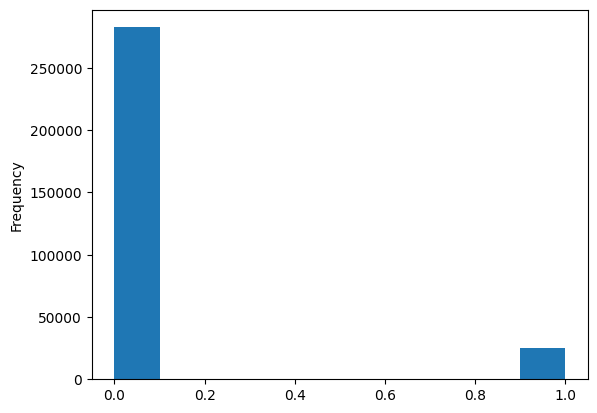

In [ ]:
# Investivating how the target variable is distributed
df_cleaned['TARGET'].astype(int).plot.hist();

There are way more loans that were repaid on time than loans that were not repaid. Simplest model could just be to assign all data as 0. I'd probably be 95% accurate. But that's not exactly the goal.

# Modeling

## Baseline Model: Decision Tree

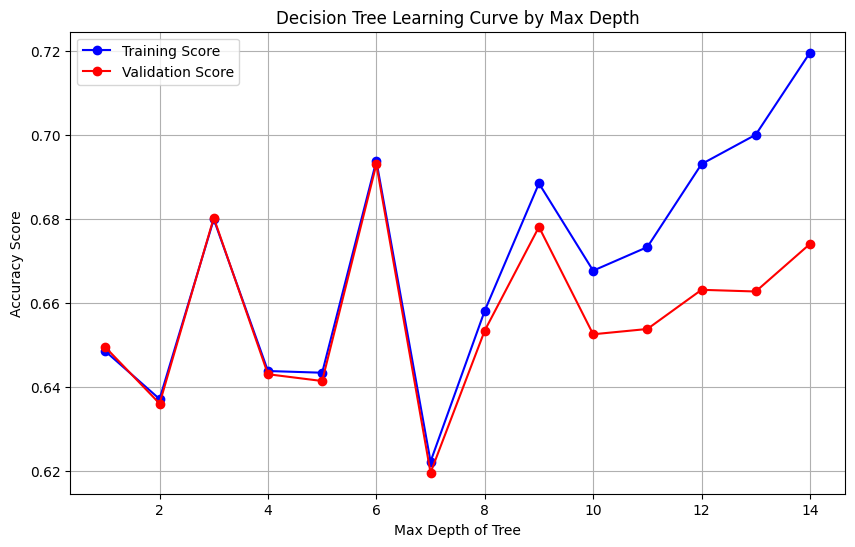

In [ ]:
# Learning Curve
max_depths = range(1, 15) # Test depths from 1 to 15
train_scores = []
test_scores = []

for depth in max_depths:
    clf = DecisionTreeClassifier(
            criterion="gini",
            max_depth=depth,
            min_samples_split=5,
            random_state=42,
            class_weight='balanced'
    )
    clf.fit(X_train, y_train)

    # Score on training and test data
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, 'o-', color="blue", label="Training Score")
plt.plot(max_depths, test_scores, 'o-', color="red", label="Validation Score")

plt.title("Decision Tree Learning Curve by Max Depth")
plt.xlabel("Max Depth of Tree")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True)
plt.show()


Learning Curve:
Underfitting (Low Depth, max_depth < 6): Both training and validation scores are low and close together. The model is too simple (high bias).

Optimal Point (max_depth = 6): The validation score reaches its peak. This is the point of optimal trade-off for this model.

Overfitting (High Depth, max_depth > 6): The training score continues to climb, while the validation score consistently drops. The growing gap between the two lines shows the model is memorizing the training data (high variance) and losing its ability to generalize.

Based on this curve, the optimal max_depth for the Decision Tree is approximately 6 or 7.

In [ ]:
# GridSearchCV automates the process of testing multiple hyperparameter combinations
# using cross-validation, which is more robust than a single train/test split.

print("--- Starting GridSearchCV for Decision Tree ---")
# Define the parameter grid to search.
param_grid = {
    'max_depth': [5, 6, 7, 8, 9],
    'min_samples_split': [10, 20, 40],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

# Instantiate the Decision Tree Classifier
# Use class_weight='balanced' to handle the imbalanced dataset.
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation.
# scoring='roc_auc' is a better metric for imbalanced classification than accuracy.
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_dt = grid_search.best_estimator_
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best cross-validated ROC AUC score: {grid_search.best_score_:.4f}")

--- Starting GridSearchCV for Decision Tree ---
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best Parameters found by GridSearchCV:
{'ccp_alpha': 0.0, 'max_depth': 6, 'min_samples_split': 10}
Best cross-validated ROC AUC score: 0.7104


This confirms that the max depth is 6. Interesting that the best ccp_alpha is 0.


--- Evaluating Best Tuned Model ---
--- Tuned Decision Tree Evaluation ---
Training Accuracy: 0.6938
Test Accuracy:     0.6930
Test F1 Score (Test): 0.2461

--- Test Set Classification Report ---
              precision    recall  f1-score   support

      Repaid       0.95      0.70      0.81     84806
     Default       0.15      0.62      0.25      7448

    accuracy                           0.69     92254
   macro avg       0.55      0.66      0.53     92254
weighted avg       0.89      0.69      0.76     92254



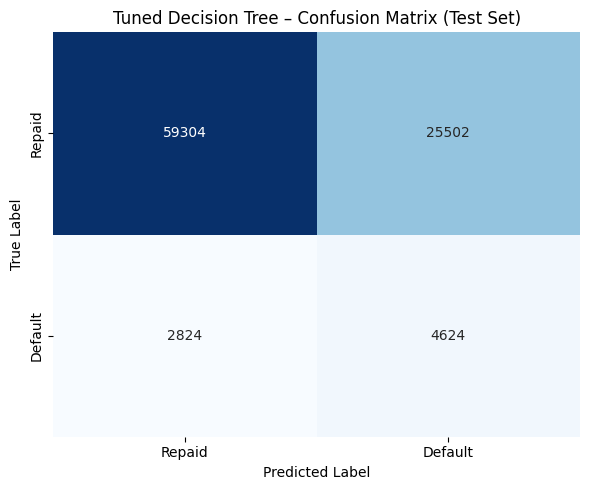

In [ ]:
# Model Evaluation
print("\n--- Evaluating Best Tuned Model ---")
name = "Tuned Decision Tree"

# Get predictions from the best model for both train and test sets
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)

# Calculate metrics
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"--- {name} Evaluation ---")
print(f"Training Accuracy: {acc_train:.4f}")
print(f"Test Accuracy:     {acc_test:.4f}")
print(f"Test F1 Score (Test): {f1_test:.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_test, target_names=['Repaid', 'Default']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Repaid', 'Default'], yticklabels=['Repaid', 'Default'])
plt.title(f"{name} – Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The model correctly identifies 4,624 defaulters (True Positives). This reduces the number of costly False Negatives. But, there is a large number of False Positives (25,502). The model is flagging many legitimate customers as potential defaulters. For a credit institution, this is generally a more acceptable error than missing actual defaults.


--- Visualizing Feature Importance ---


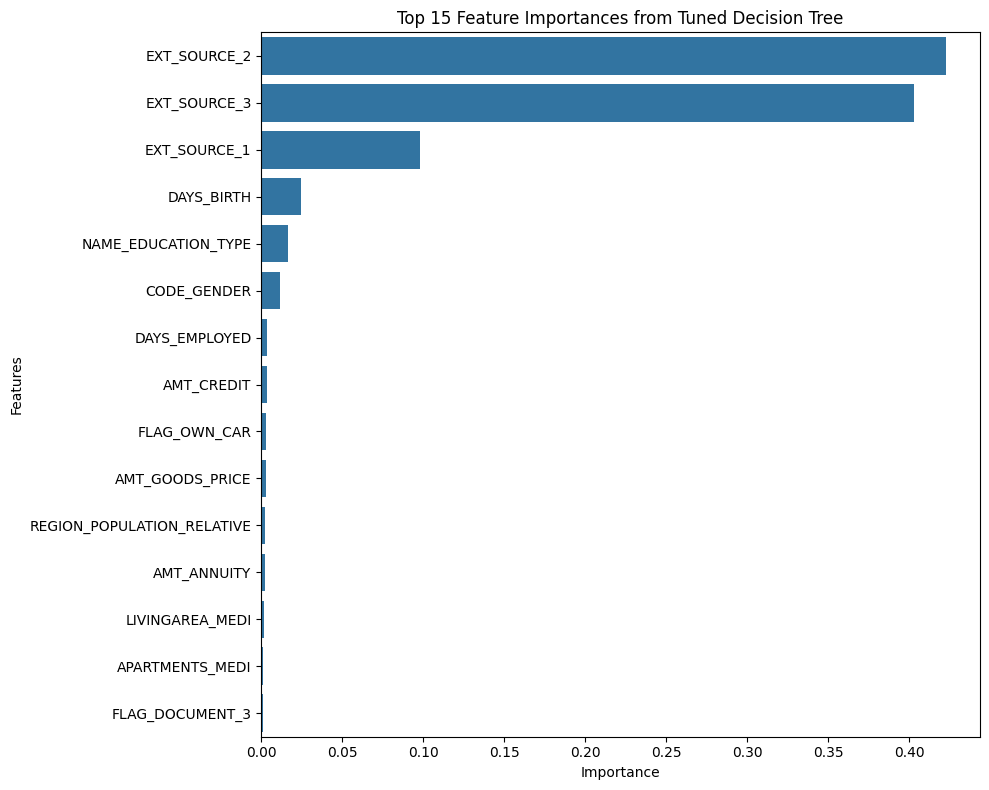

In [ ]:
# Feature Importance Visualization

print("\n--- Visualizing Feature Importance ---")
# Get feature importances from the best model
importances = best_dt.feature_importances_

# Create a pandas Series for easier handling and sorting
feature_importance_df = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Select the top N features to display
top_n = 15
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_df.head(top_n), y=feature_importance_df.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Tuned Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


--- Visualizing the Structure of the Best Tree (Top 3 Levels) ---


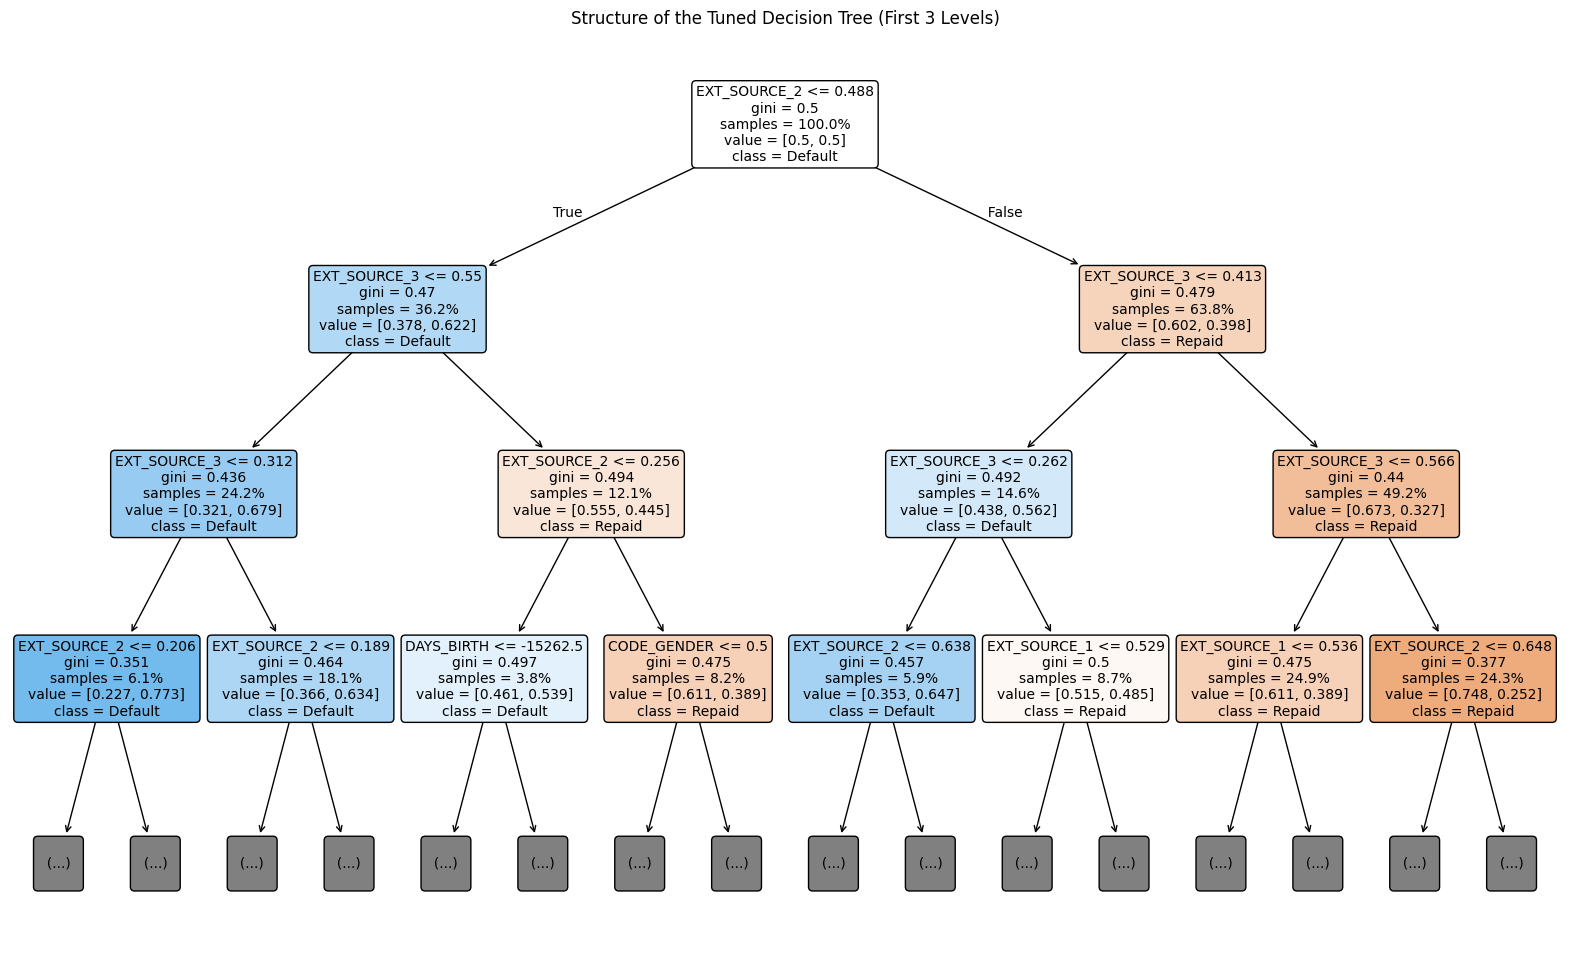

In [ ]:
# Visualize the Best Decision Tree
print("\n--- Visualizing the Structure of the Best Tree (Top 3 Levels) ---")
plt.figure(figsize=(20, 12))
plot_tree(best_dt,
          max_depth=3, # Limit depth for readability
          feature_names=X_train.columns,
          class_names=['Repaid', 'Default'],
          filled=True,
          fontsize=10,
          proportion=True,
          rounded=True)
plt.title("Structure of the Tuned Decision Tree (First 3 Levels)")
plt.show()


--- Plotting Precision-Recall Curve ---


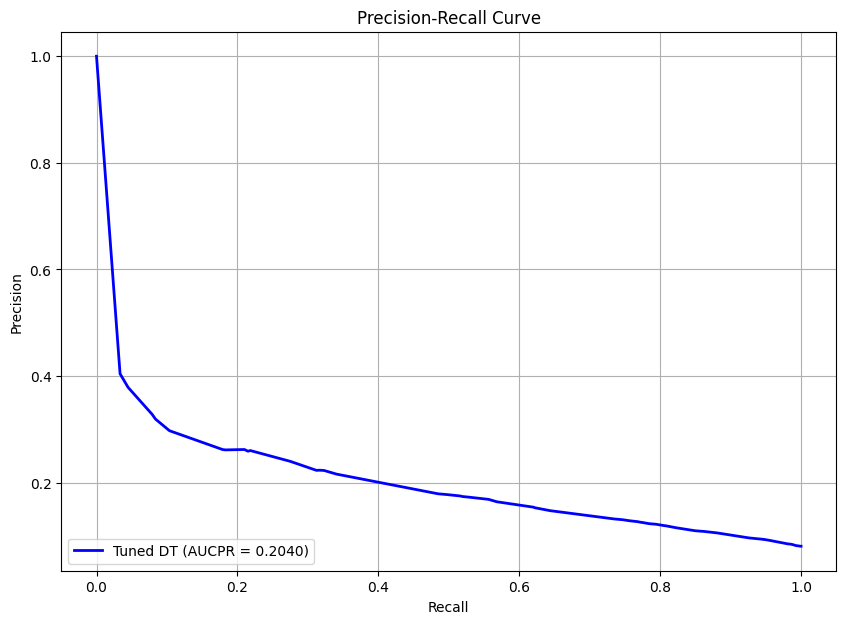

In [ ]:
# Precision-Recall Curve

print("\n--- Plotting Precision-Recall Curve ---")
# Get probabilities for the positive class (1) from both models
y_proba_best = best_dt.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and AUCPR for the best tuned model
precision_best, recall_best, _ = precision_recall_curve(y_test, y_proba_best)
aucpr_best = auc(recall_best, precision_best)

# Plot the PR curves
plt.figure(figsize=(10, 7))
plt.plot(recall_best, precision_best, color='blue', lw=2,
         label=f'Tuned DT (AUCPR = {aucpr_best:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

##  Gradient Boosting

In [ ]:
# This code takes at least 15 minutes to run

print("\n--- Starting RandomizedSearchCV for Gradient Boosting ---")
sample_weights = np.where(y_train == 1, len(y_train) / (2 * (y_train == 1).sum()), len(y_train) / (2 * (y_train == 0).sum()))

# Define a wider parameter grid for randomized search
gb_param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0]
}
gb_classifier = GradientBoostingClassifier(random_state=42)
# n_iter controls how many random combinations are tested.
gb_rand_search = RandomizedSearchCV(estimator=gb_classifier, param_distributions=gb_param_dist,
                                    n_iter=8, cv=3, scoring='roc_auc', verbose=2,
                                    n_jobs=-1, random_state=42)

gb_rand_search.fit(X_train, y_train, sample_weight=sample_weights)
best_gb = gb_rand_search.best_estimator_
print("\nBest Parameters for Gradient Boosting:")
print(gb_rand_search.best_params_)
print(f"Best cross-validated ROC AUC score: {gb_rand_search.best_score_:.4f}")


--- Starting RandomizedSearchCV for Gradient Boosting ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Parameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
Best cross-validated ROC AUC score: 0.7529


Beats the ROC AUC score of the baseline (Best cross-validated ROC AUC score: 0.7104 vs 0.7529:)

Best Parameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
Best cross-validated ROC AUC score: 0.7529

Sample weights are used to address the class imbalance in your dataset.

Because you have far more "Repaid" (class 0) than "Default" (class 1) instances, a standard model will become very good at predicting "Repaid" and ignore the rare "Default" class, as you saw with your initial confusion matrix.

The sample_weights line of code counteracts this by telling the model to pay more attention to the minority class. It does this by assigning a higher weight to each "Default" sample and a lower weight to each "Repaid" sample.

When the model is training, the error from misclassifying a high-weight "Default" sample is magnified. This larger penalty forces the model to work harder to learn the patterns that identify defaulters, leading to a more useful and balanced model. It is an alternative method to using the class_weight='balanced' parameter you used for the Decision Tree.


--- Visualizing Training vs. Validation Loss ---


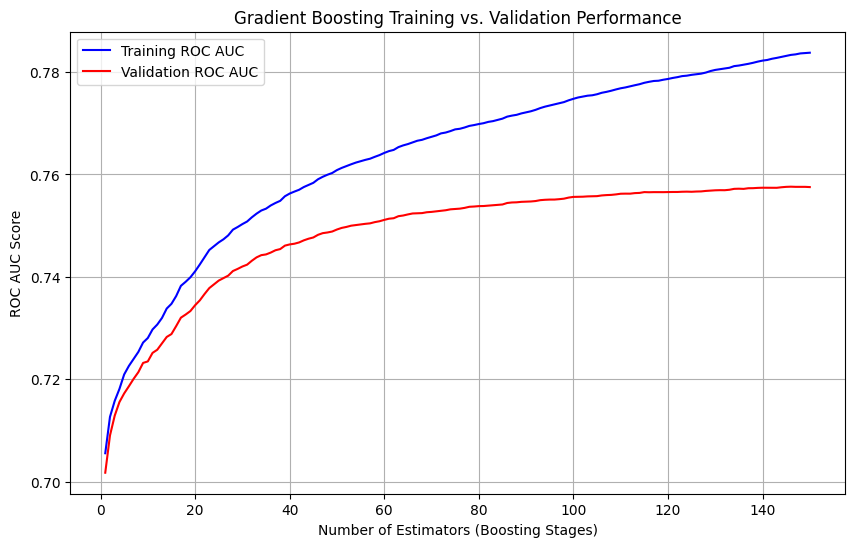


--- Visualizing Feature Importance for Gradient Boosting ---


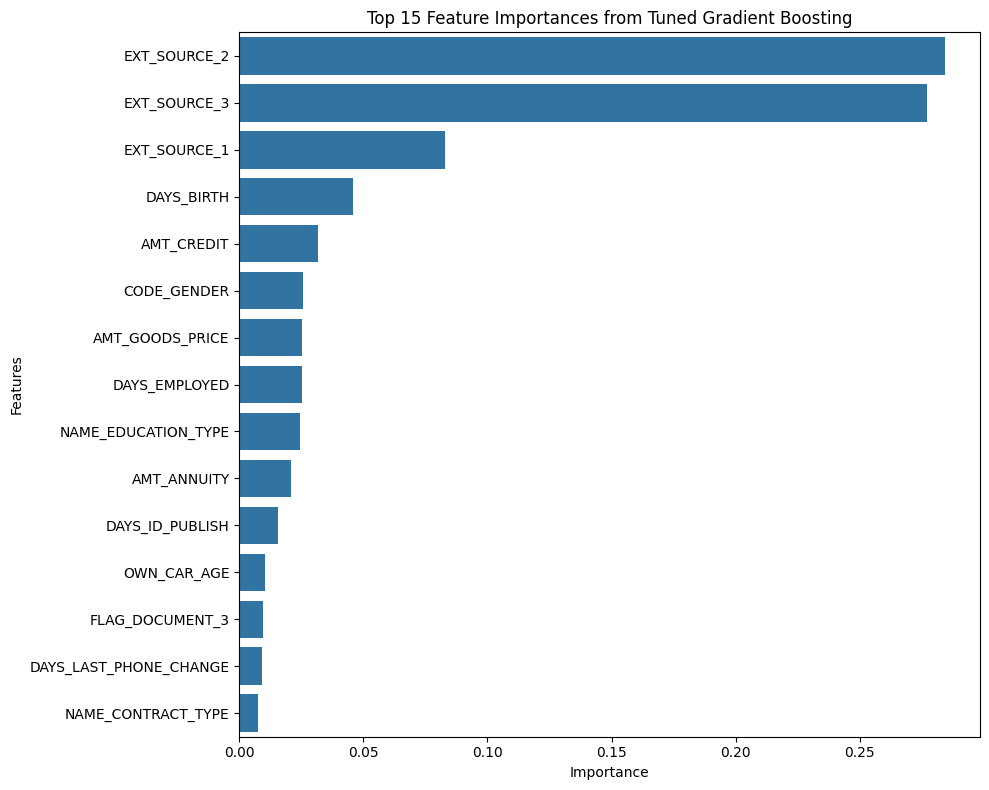


--- Plotting PR Curve for Gradient Boosting ---


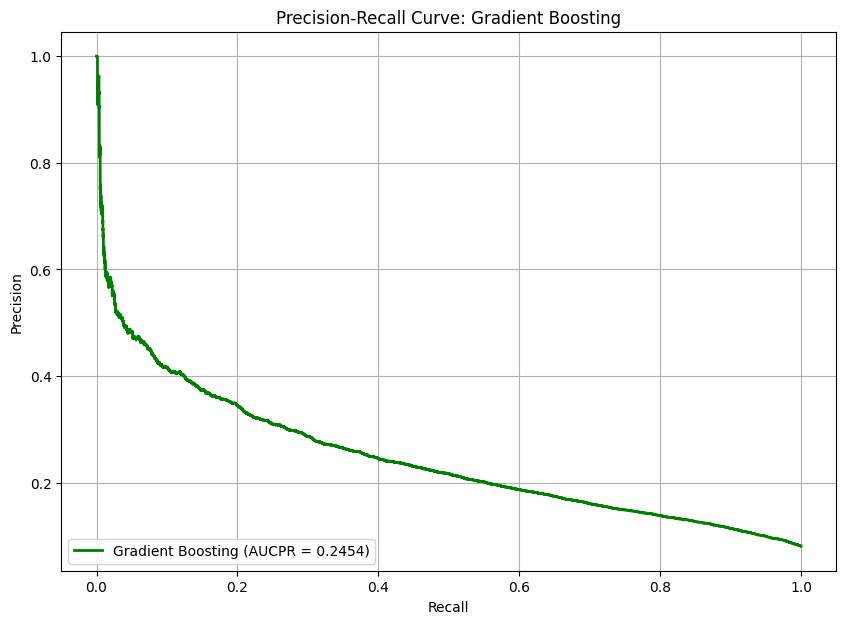

In [ ]:
# --- 2. Training vs. Validation Loss Visualization ---

print("\n--- Visualizing Training vs. Validation Loss ---")
# Get the training and validation scores at each boosting stage
# The 'staged_predict_proba' method gives us predictions at each iteration.
train_scores = []
val_scores = []

for i, y_pred_proba in enumerate(best_gb.staged_predict_proba(X_train)):
    train_scores.append(roc_auc_score(y_train, y_pred_proba[:, 1]))

for i, y_pred_proba in enumerate(best_gb.staged_predict_proba(X_test)):
    val_scores.append(roc_auc_score(y_test, y_pred_proba[:, 1]))

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, 'b-', label='Training ROC AUC')
plt.plot(range(1, len(val_scores) + 1), val_scores, 'r-', label='Validation ROC AUC')
plt.xlabel('Number of Estimators (Boosting Stages)')
plt.ylabel('ROC AUC Score')
plt.title('Gradient Boosting Training vs. Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Feature Importance Visualization ---
print("\n--- Visualizing Feature Importance for Gradient Boosting ---")
# Get feature importances from the best model
importances_gb = best_gb.feature_importances_

# Create a pandas Series for easier handling and sorting
feature_importance_gb_df = pd.Series(importances_gb, index=X_train.columns).sort_values(ascending=False)

# Select the top N features to display
top_n = 15
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_gb_df.head(top_n), y=feature_importance_gb_df.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Tuned Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# --- 4. Compare PR Curves ---
print("\n--- Plotting PR Curve for Gradient Boosting ---")
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_proba_gb)
aucpr_gb = auc(recall_gb, precision_gb)

plt.figure(figsize=(10, 7))
plt.plot(recall_gb, precision_gb, color='green', lw=2,
         label=f'Gradient Boosting (AUCPR = {aucpr_gb:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Gradient Boosting')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


--- Comparing Learning Rate and Number of Estimators ---
Training model with learning_rate=0.01...
Training model with learning_rate=0.1...
Training model with learning_rate=0.3...


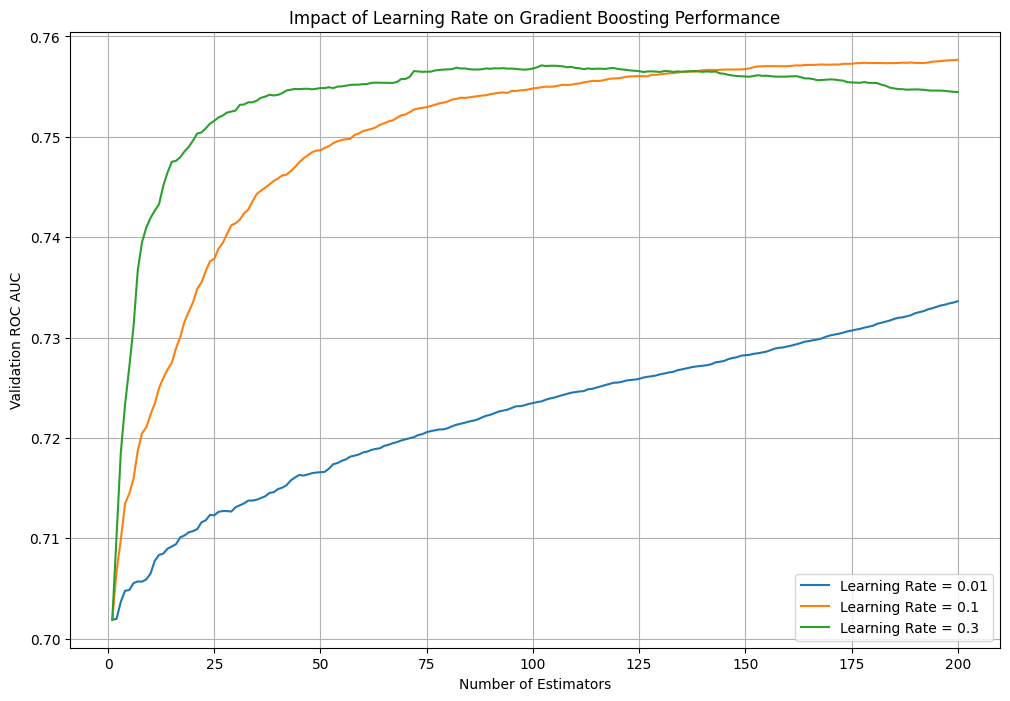

In [ ]:
# --- 5. Effect of Learning Rate and Number of Estimators (New Section) ---
# This one takes at least 20 minutes.
print("\n--- Comparing Learning Rate and Number of Estimators ---")
learning_rates = [0.01, 0.1, 0.3]
n_estimators = 200 # Max estimators to check
fixed_max_depth = 4

plt.figure(figsize=(12, 8))

for lr in learning_rates:
    print(f"Training model with learning_rate={lr}...")
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=fixed_max_depth,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Get validation scores at each stage
    val_scores_lr = [roc_auc_score(y_test, y_proba[:, 1]) for y_proba in model.staged_predict_proba(X_test)]

    plt.plot(range(1, n_estimators + 1), val_scores_lr, label=f"Learning Rate = {lr}")

plt.xlabel("Number of Estimators")
plt.ylabel("Validation ROC AUC")
plt.title("Impact of Learning Rate on Gradient Boosting Performance")
plt.legend()
plt.grid(True)
plt.show()


--- Test Set Classification Report ---
              precision    recall  f1-score   support

      Repaid       0.96      0.70      0.81     84806
     Default       0.17      0.68      0.27      7448

    accuracy                           0.70     92254
   macro avg       0.56      0.69      0.54     92254
weighted avg       0.90      0.70      0.77     92254



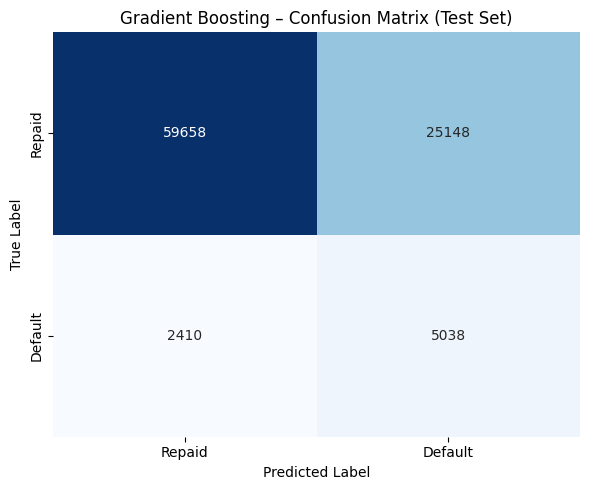

In [ ]:
# Get class predictions (0 or 1) on the test set
y_pred_gb = best_gb.predict(X_test)

# Print the classification report
print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_gb, target_names=['Repaid', 'Default']))

# Generate and plot the confusion matrix
name = "Gradient Boosting"
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Repaid', 'Default'], yticklabels=['Repaid', 'Default'])
plt.title(f"{name} – Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## XGBoost

In [ ]:
# XGBoost Classifier with RandomizedSearchCV
print("\n--- Starting RandomizedSearchCV for XGBoost ---")
# Handle class imbalance using scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_param_dist = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_classifier = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_rand_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    random_state=42
)

xgb_rand_search.fit(X_train, y_train)

print("\nBest Parameters found by RandomizedSearchCV:")
print(xgb_rand_search.best_params_)

print(f"Best cross-validated ROC AUC score: {xgb_rand_search.best_score_:.4f}")


--- Starting RandomizedSearchCV for XGBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   5.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   6.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   4.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9; total time=   1.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9; total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9; total time=   1.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5; total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5; total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, n_estimators=500, subsample=0.7; total time=   5.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, n_estimators=500, subsample=0.7; total time=   3.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, n_estimators=500, subsample=0.7; total time=   3.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.9; total time=   4.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.9; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.9; total time=   2.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters found by RandomizedSearchCV:
{'subsample': 0.9, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best cross-validated ROC AUC score: 0.7538


In [ ]:
# Train the final model with best params and early stopping
print("\n--- Training final XGBoost model with early stopping ---")
best_params = xgb_rand_search.best_params_
best_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    **best_params
)

eval_set = [(X_train, y_train), (X_test, y_test)]

early_stopping_callback = EarlyStopping(rounds=30, save_best=True)
best_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


--- Training final XGBoost model with early stopping ---


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, ...)


--- Visualizing Training vs. Validation Loss for XGBoost ---


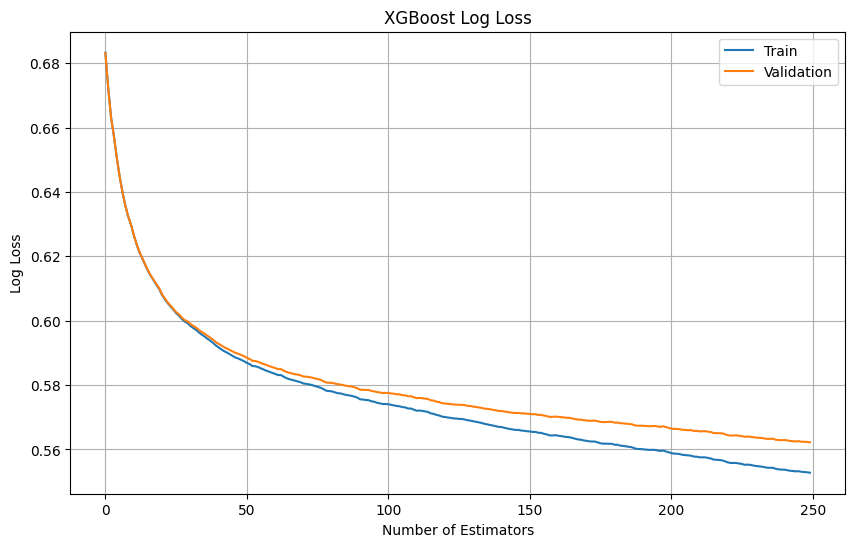


--- Visualizing Feature Importance for XGBoost ---


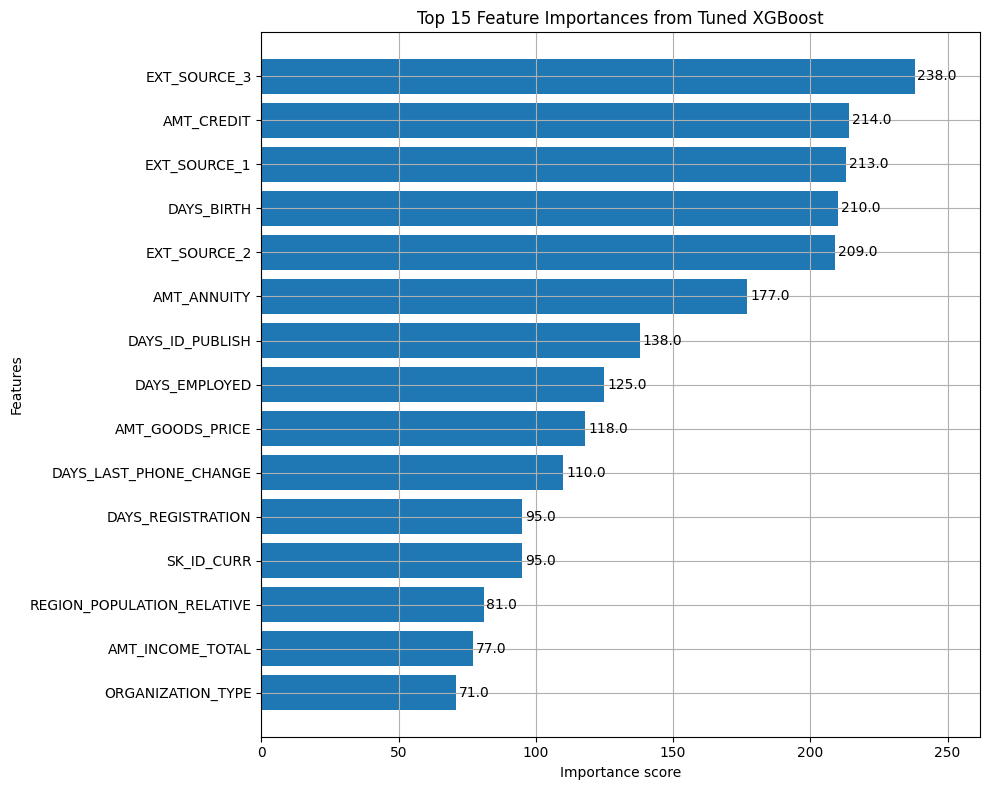


--- Plotting PR Curve for XGBoost ---


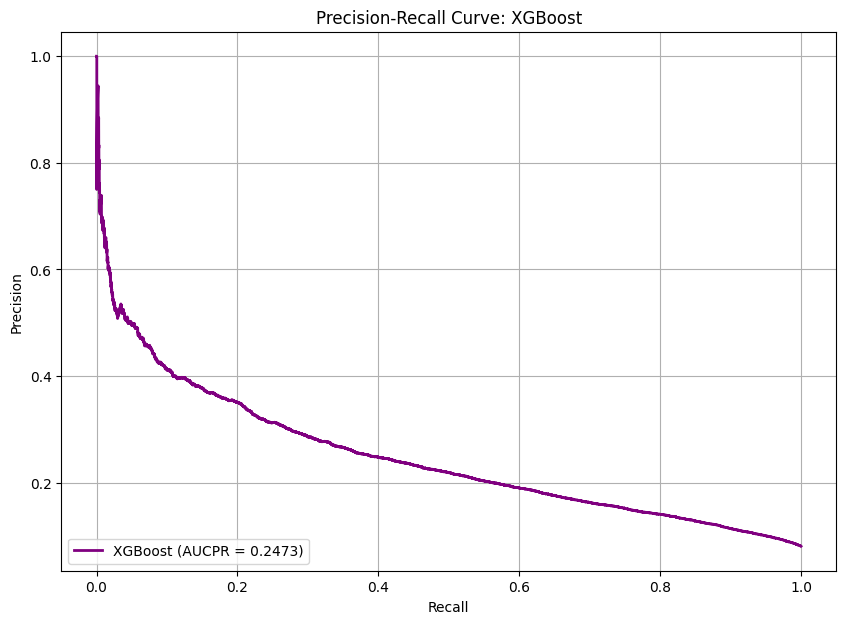


--- Generating Confusion Matrix for Best XGBoost Model ---

--- Test Set Classification Report ---
              precision    recall  f1-score   support

      Repaid       0.96      0.71      0.82     84806
     Default       0.17      0.67      0.27      7448

    accuracy                           0.71     92254
   macro avg       0.57      0.69      0.54     92254
weighted avg       0.90      0.71      0.77     92254



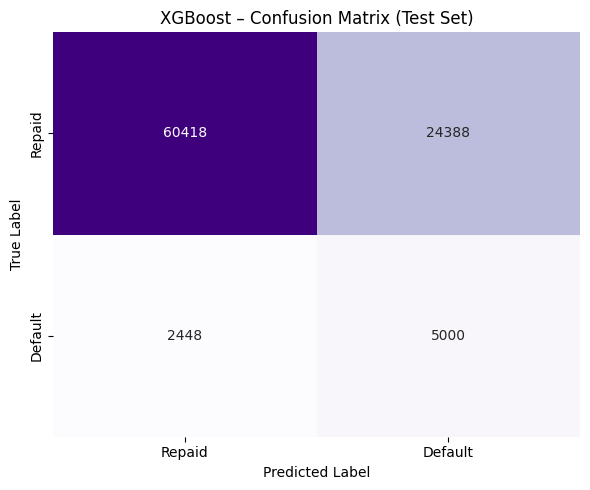

In [ ]:
# Training vs. Validation Loss Visualization (from Early Stopping)
print("\n--- Visualizing Training vs. Validation Loss for XGBoost ---")
results = best_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Number of Estimators')
plt.title('XGBoost Log Loss')
plt.grid(True)
plt.show()

# Feature Importance Visualization
print("\n--- Visualizing Feature Importance for XGBoost ---")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_xgb, ax=ax, max_num_features=15, height=0.8)
plt.title('Top 15 Feature Importances from Tuned XGBoost')
plt.tight_layout()
plt.show()

# PR Curve
print("\n--- Plotting PR Curve for XGBoost ---")
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
aucpr_xgb = auc(recall_xgb, precision_xgb)

plt.figure(figsize=(10, 7))
plt.plot(recall_xgb, precision_xgb, color='purple', lw=2,
         label=f'XGBoost (AUCPR = {aucpr_xgb:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: XGBoost')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Final Model Evaluation: Confusion Matrix and Report
print("\n--- Generating Confusion Matrix for Best XGBoost Model ---")
y_pred_xgb = best_xgb.predict(X_test)
print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Repaid', 'Default']))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=['Repaid', 'Default'], yticklabels=['Repaid', 'Default'])
plt.title("XGBoost – Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


--- Analyzing the Effect of Learning Rate on XGBoost Performance ---
Training model with learning_rate = 0.01...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:27:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model with learning_rate = 0.1...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:27:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training model with learning_rate = 0.3...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:27:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


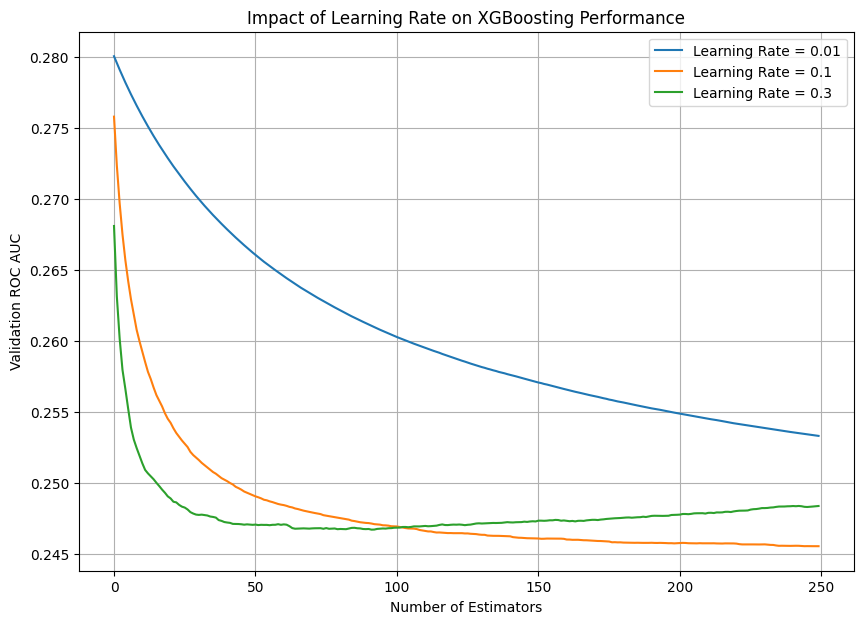

In [ ]:
# Effect of Learning Rate
print("\n--- Analyzing the Effect of Learning Rate on XGBoost Performance ---")
learning_rates = [0.01, 0.1, 0.3]
plt.figure(figsize=(10, 7))

for lr in learning_rates:
    print(f"Training model with learning_rate = {lr}...")
    # Initialize model with the current learning rate
    xgb_lr_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        learning_rate=lr,
        n_estimators=250,
        max_depth=4,       # Fixed depth for fair comparison
        random_state=42,
        use_label_encoder=False,
        tree_method=tree_method,
        n_jobs=-1
    )

    # Fit the model with early stopping
    eval_set = [(X_test, y_test)]
    xgb_lr_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Get validation results
    results = xgb_lr_model.evals_result()
    val_logloss = results['validation_0']['logloss']

    # Plot the validation performance
    plt.plot(val_logloss, label=f'Learning Rate = {lr}')

plt.xlabel("Number of Estimators")
plt.ylabel("Validation ROC AUC")
plt.title("Impact of Learning Rate on XGBoosting Performance")
plt.legend()
plt.grid(True)
plt.show()